In [1]:
#import settings
import mysql.connector
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="M@sters@21",
    database="TwitterDB",
    charset = 'utf8'
)


TRACK_WORDS = ['jetblue']
TABLE_NAME = "jetblue"
TABLE_ATTRIBUTES = "id_str VARCHAR(255), created_at DATETIME, text VARCHAR(255), \
            polarity INT, subjectivity INT, user_created_at VARCHAR(255), user_location VARCHAR(255), \
            user_description VARCHAR(255), user_followers_count INT, longitude DOUBLE, latitude DOUBLE, \
            retweet_count INT, favorite_count INT"

Jetblue Negative Tweets Monitor: 
  2019-10-27 03:09:59  RT @VeganNobody: @coffeespoonie @JetBlue Wtf! I'm so sorry that this hasn't been resolved yet. Step tf up @JetBlue You guys should be embar
  2019-10-27 03:11:03  Ive never flown @JetBlue before, but this has been a truly miserable experience #neveragain


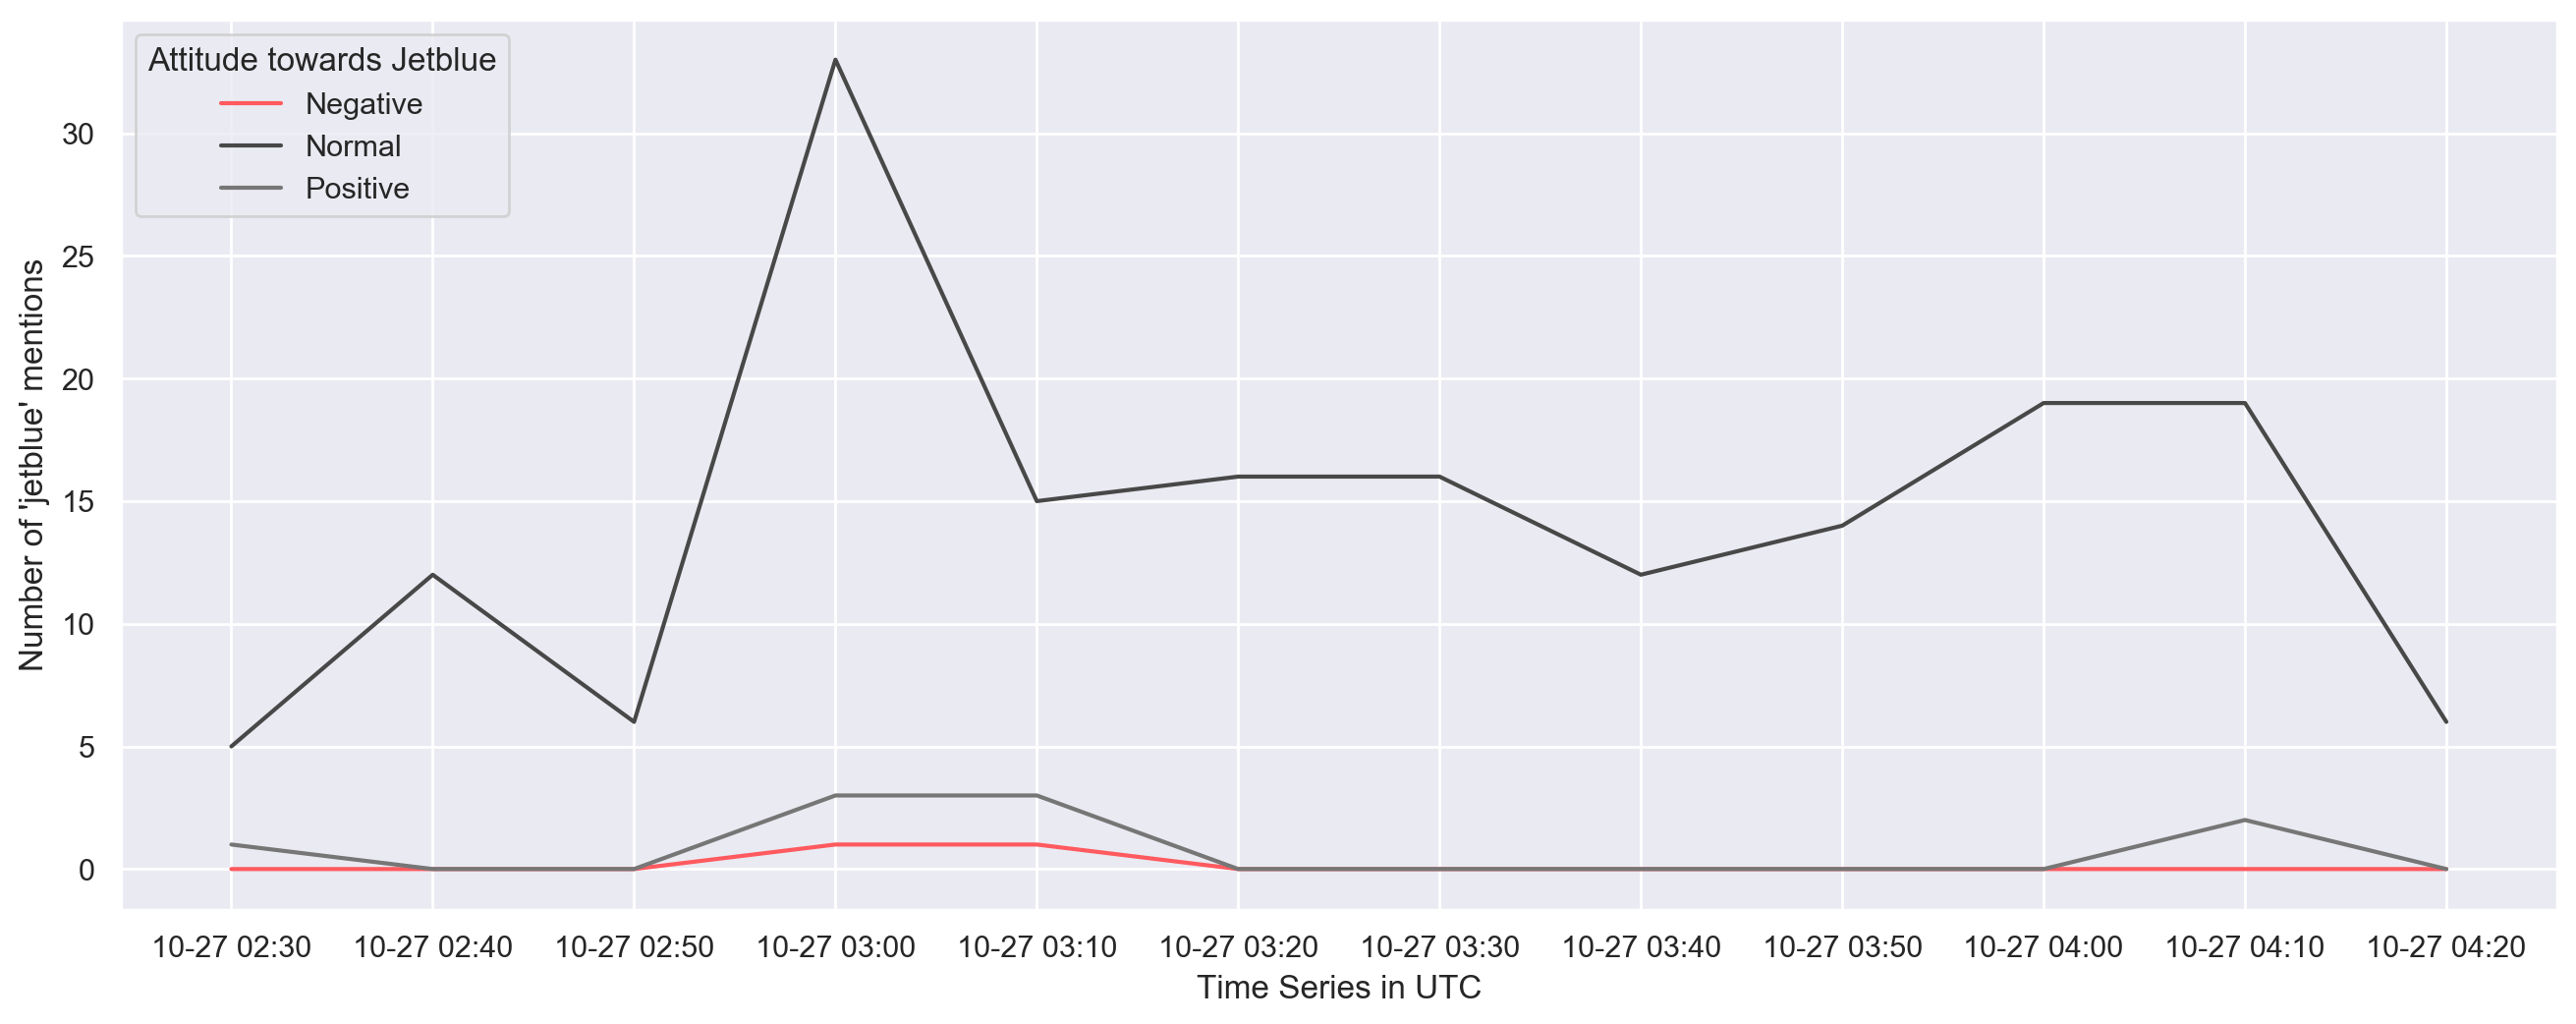

In [2]:
# Load data from MySQL
df = pd.read_sql('SELECT id_str, text, created_at, polarity, user_location FROM {}'.format(TABLE_NAME), con=db_connection)
# UTC for date time at default
df['created_at'] = pd.to_datetime(df['created_at'])
print("Jetblue Negative Tweets Monitor: ")
for index, tweets in df[df['polarity'] == -1].iterrows():
    print("  " +str(tweets[2]) + "  " + tweets[1])


# Clean and transform data to enable time series
result = df.groupby([pd.Grouper(key='created_at', freq='10min'), 'polarity']).count() \
        .unstack(fill_value=0).stack().reset_index()
result['created_at'] = pd.to_datetime(result['created_at']).apply(lambda x: x.strftime('%m-%d %H:%M'))


# Plot Line Chart for monitoring brand awareness on Twitter
mpl.rcParams['figure.dpi']= 200
plt.figure(figsize=(16, 6))
sns.set(style="darkgrid")
ax = sns.lineplot(x = "created_at" ,y="id_str", hue='polarity', data=result,\
                  palette=sns.color_palette(["#FF5A5F","#484848", "#767676"]))
ax.set(xlabel='Time Series in UTC', ylabel="Number of '{}' mentions".format(TRACK_WORDS[0]))
plt.legend(title='Attitude towards Jetblue', loc='upper left', labels=['Negative', 'Normal', 'Positive'])
sns.set(rc={"lines.linewidth": 1})
plt.show()

In [3]:
# Next step: find out geo-distribution of users
# Find where tweets come from according to their users' location
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Columbus, Oh")
print((location.latitude, location.longitude))
location.address

(39.9622601, -83.0007065)


'Columbus, Franklin County, Ohio, United States of America'